<a href="https://colab.research.google.com/github/blakebordelon/kernel_blogs/blob/master/kernelblog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Kernel Regression Problem Efficiently


This is the second blog post in a $k$-part series. 

In my last [post](https://colab.research.google.com/drive/1XNVNLcUzlpWT0jwS5__p0qXhF7P9tGqd#scrollTo=H5Z4NUdSxgVy), I introduced kernel regression, its mathematical definition, and a [physics-inspired theory of generalization](https://arxiv.org/abs/2002.02561) that agrees well with kernel regression experiments. In this post, we will focus on the *optimization* or training component of the algorithm as opposed to generalization. For those of you most fascinated with the statistical (generalization) puzzles of ML, the next post will be coauthored with Abdulkadir Canatar on [sample-wise multiple descents](https://arxiv.org/abs/2006.13198) when the learning problem is noisy and how we can understand the test error with a phase diagram. 

Today, however, our focus is very practical. We want to solve the kernel regression optimization problem numerically. The main issues we will discuss

1.   Why kernel methods have historically been limited to small datasets.
2.   How recent algorithmic advances allow efficient training of *much* larger datasets, even those with [billions of data points](https://arxiv.org/abs/2006.10350).

We will discover that solving this problem efficiently is equivalent to solving a large linear system of equations efficiently. We will mostly use Ma and Belkin's [Eigenpro](https://arxiv.org/abs/1703.10622) paper as a guide on this journey. It is quite a good introduction to these issues and goes in much greater depth than I will here.


## Problem Definition and Linear Algebra Formulation

The setting of the learning problem requires we introduce the following objects

1. Supervised learning dataset $\mathcal D = \{ (\mathbf x_1,y_1),...,(\mathbf x_p,y_p) \}$ with $p$ data points. 

2. A reproducing kernel Hilbert space (RKHS) $\mathcal H$ with reproducing kernel $K$. The Hilbert space has an inner product (for functions) denoted as $\left< \cdot , \cdot \right>_{\mathcal H}$. The *reproducing property* is $\left< g , K(\cdot, \mathbf x)  \right>_{\mathcal H} = g(\mathbf x)$
3. The objective function that we want to optimize

$$ \min_{f \in \mathcal H} \sum_{i=1}^p \ell(f(\mathbf x_i), y_i) + \lambda \left< f,f\right>_{\mathcal H}$$

where $\ell(\cdot,\cdot)$ is a convex loss function (least squares, cross entropy, etc). 

If any of these things look unfamiliar or stress inducing, I encourage the reader to see the [previous post](https://colab.research.google.com/drive/1XNVNLcUzlpWT0jwS5__p0qXhF7P9tGqd#scrollTo=H5Z4NUdSxgVy), where we explain Hilbert spaces in greater detail.

### Representer Theorem

Implicit in the last post was a [key insight](https://en.wikipedia.org/wiki/Representer_theorem) that makes kernel methods tractable. The optimization problem posed above operates in an *infinite dimensional function space* $\mathcal H$, yet for reasons we shall see shortly, the solution lies only in a *finite (p) dimensional sub-space*. 

The key observation can be made by decomposing the function $f$ into $S = \text{span}\{ K(\cdot, \mathbf x_i) \}_{i=1}^p$ and it's orthogonal complement $\overline{S}$.

$$ f(\mathbf x) = \sum_{i=1}^p \alpha_i K(\mathbf x,\mathbf x_i) + v(\mathbf x)$$

where $v(\cdot) \in \overline{S}$. By the Reproducing property of the kernel, the empirical loss $\sum_i \ell(f(\mathbf x_i),y_i)$ is independent of $v$ since

$$ f(\mathbf x_i) = \left< f, K(\mathbf x_i,\cdot) \right>_{\mathcal H} = \sum_j \alpha_j \left< K(\mathbf x_j, \cdot),K(\mathbf x_i,\cdot) \right>_{\mathcal H} + \left< v, K(\mathbf x_i,\cdot) \right>_{\mathcal H} = \sum_j \alpha_j K(\mathbf x_i,\mathbf x_j)$$

The Hilbert norm penalty does, however, depend on $v$ and achieves its minimum only when $v=0$

$$ \left< f, f \right>_{\mathcal H} = \sum_{ij} \alpha_i \alpha_j K(\mathbf x_i,\mathbf x_j) + \left< v,v \right>_{\mathcal H} \geq \sum_{ij} \alpha_i \alpha_j K(\mathbf x_i,\mathbf x_j) $$

where the inequality is tight for $v = 0$. Therefore, the solution to the optimization problem posed above lies in $f \in S$. 

### Least Squares

If we specialize to least squares error for empirical cost, we can compute $\alpha$ in closed form

$$ \min_{f \in \mathcal H} \sum_{i=1}^p (f(\mathbf x_i) - y_i)^2 + \lambda \left< f,f\right>_{\mathcal H} = \min_{\alpha \in \mathbb{R}^p} \alpha^\top \mathbf K^2 \mathbf \alpha - 2 \alpha^\top \mathbf K \mathbf y + |\mathbf y|^2 + \lambda \mathbf \alpha^\top \mathbf K \mathbf \alpha$$

Optimizing with respect this quadratic function with respect to $\mathbf \alpha $, we find that the optimum satisfies

$$ (\mathbf K + \lambda \mathbf I) \alpha = \mathbf y$$

This is just a system of $p$ equations with $p$ unknowns. Further $\mathbf K + \lambda \mathbf I$ is invertible since the kernel is positive semidefinite. Ridgeless regression $\lambda \to 0$ is possible when $\mathbf K$ is positive definite. 


## Numerical Challenge of Solving Large Linear Systems

We have discovered that to perform kernel regression with a least squares cost is the same as solving a linear system of $p$ variables with $p$ equations. 

The naive method to solve a linear system is matrix inversion. What is the numerical cost to invert a $p\times p$ matrix? 

### Numerical Scaling of Matrix Inversion








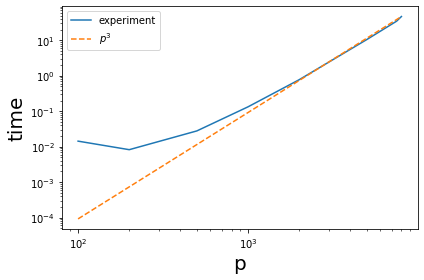

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

pvals = [100,200,500,1000,2000,5000,7500,8000]
times = []
for i,p in enumerate(pvals):
  K = np.random.standard_normal((p,p))
  start = time.perf_counter()
  Kinv = np.linalg.inv(K)
  end = time.perf_counter()
  times += [end -start]

pcube = np.array(pvals)**3
plt.loglog(pvals, times, label = 'experiment')
plt.loglog(pvals, pcube / pcube[-1] * times[-1], '--', label = r'$p^3$')
plt.legend()
plt.xlabel('p', fontsize = 20)
plt.ylabel('time', fontsize = 20)
plt.tight_layout()
plt.show()

# Straightforward Inversion Does Not Scale

### Computation
The lines for $p^3$ and the time required to invert the matrix are roughly parallel on a log-log plot, indicating that solving a $p \times p$ linear system requires $\mathcal O(p^3)$ operations. Modern machine learning datasets can have $10^6$ data points (ImageNet has roughly 1.6 M data points). Kernel methods would therefore naively require $\sim 10^{18}$ operations to solve the linear system derived above! This would be challenging even for modern [supercomputers](https://en.wikipedia.org/wiki/Supercomputer#Performance_measurement).

### Memory

Straightforward inversion techniques typically require storing in memory the entire $p \times p$ matrix. The memory requirements therefore scale like $\mathcal O(p^2)$. This quickly becomes prohibitive. To solve even MNIST or CIFAR would require several gigabytes of RAM. 



# Gradient Descent / Richardson Iteration

Can we develop an iterative algorithm to reduce the number of computations required to solve $\mathbf K \alpha = \mathbf y$?

Let's introduce the following objective function

$$ \mathcal L =  ||\mathbf K^{1/2} \alpha - \mathbf K^{-1/2} \mathbf y||^2$$

which has a global minimum $\mathcal L = 0$ at $\alpha^* = \mathbf K^{-1} \mathbf y$. Note that this cost function is not the training error $||\mathbf K \alpha - \mathbf y||^2$, but both losses have the same global minimizer. 

The gradient descent dynamics for this cost 

$$ \alpha_{t+1} - \alpha^* = \alpha_t - \eta \frac{\partial \mathcal L}{\partial \alpha} = \alpha_t - \eta (\mathbf K \alpha_t - \mathbf y) = \alpha_t - \eta \mathbf K \alpha_t  + \eta \mathbf K \alpha^* = (\mathbf I - \eta \mathbf K) (\alpha_t - \alpha^*)$$

The solution to the recursion above is  

$$\alpha_t - \alpha^* = - (\mathbf I - \eta \mathbf K)^t \alpha^*$$

Great! So there is an iterative procedure that we could use to find $\alpha$ rather than inverting the gram matrix. Each step of gradient descent costs $\mathcal O(p^2)$ operations. For this method to outperform the naive matrix inversion, this algorithm needs to converge in fewer than $\sim p$ iterations. Does this happen in realistic situations?

## Dynamics under Eigendecomposition

It is much easier to analyze trajectories of Richardson iteration in the eigenbasis of the kernel $\mathbf K$. We saw in the last blog post that this decomposition plays a key role in understanding generalization as well. 

$$ K = \sum_{k=1}^p \lambda_k \mathbf u_k \mathbf u_k^\top \ , \ \alpha_t - \alpha* = \sum_{k=1}^p e_k(t) \mathbf u_k $$

The dynamics decouple in this basis and give
$$ e_k(t) = (1-\eta \lambda_k)^t e_k(0) $$

Therefore, exponential convergence of each $e_k(t) \to 0$ is attained provided we choose a small enough learning rate
 $$\forall k \ , \ |1-\eta \lambda_k| < 1 \implies \eta < \frac{2}{\lambda_{max}} $$


### Problem: Large Range of Eigenvalues

Typical kernel matrices can have very large range of eigenvalues that scale over multiple decades. The rate of convergence for the smallest eigenvalue is
$$ e_p = (1-\eta \lambda_p)^t e_p(0)$$
